# Bike Tour YVR

## Description:
- Your friend gives you a photo of some location in the Vancouver area
- Using a photo you've taken of your current location, Bike Tour YVR will produce a route to your friends location, along with some interesting amenities to check out along the way

## Requirements:
- Before running this notebook, please run `$ pip3 install -r requirements.txt` to install required libraries
- Refer to `README.md` for detailed installation instructions

## Output
- A map is produced in this notebook, the route from the users location to their friends, along with the recommened amenities to visit along the two routes.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

import bike_tour_yvr as bty
import bike_tour_maps as btm

### Set photos here

In [2]:
user_photo = bty.USER_PHOTO     # sample.jpg
friend_photo = bty.FRIEND_PHOTO # stanley.jpg

### Prepare data

In [3]:
# Get current location and destination

# Current location
gif = bty.get_gps_exif(user_photo)
lat_lon_origin = bty.get_lat_lon(gif)

# Destination
gif_destination = bty.get_gps_exif(friend_photo)
lat_lon_destination = bty.get_lat_lon(gif_destination)

In [4]:
# Get amenities in Vancouver
amenities = bty.get_amenities()

# Add distance of amenities from current location
amenities["distance(km)"] = bty.distance(
    lat_lon_origin['lat'], lat_lon_origin['lon'],
    amenities["lat"], amenities["lon"]
)

### Use Elbow-Method to find optimal 'k' clusters for K Means Model
- Finding indicates the optimal *k* = 3

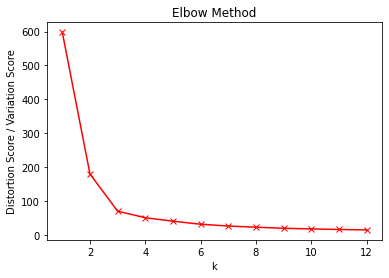

In [5]:
nn = amenities[['lon','lat']]

distortions = []
K = range(1,13)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(nn)
    kmeanModel.fit(nn)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Distortion Score / Variation Score')
plt.title('Elbow Method')
plt.show()

### Create KMeans model

In [6]:
model = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=3)
    )

X = amenities[['lon','lat']]
model.fit(X);

In [7]:
# Add cluster id to amenities

amenities['cluster'] = model.predict(amenities[['lon','lat']])

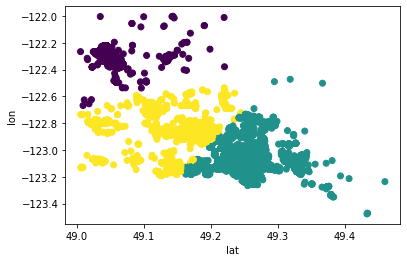

In [8]:
# Display plot of clusters by location

plt.scatter(amenities['lat'], amenities['lon'], c = amenities['cluster'], label =  amenities['cluster'])
plt.xlabel('lat')
plt.ylabel('lon')
plt.show()

In [9]:
# Use the model to determine which cluster the user is in

x = model.predict([[lat_lon_origin['lon'],lat_lon_origin['lat']]])
print("User cluster is in :",int(x))

User cluster is in : 1


### Select which amenities the user is interested in seeing
- Possible values:
    - `family_friendly`
    - `foodie`
    - `dessert_crawl`
    - `tourist`
    - `pub_crawl`

In [10]:
# Select amenity type

amenity_type = 'pub_crawl'

In [11]:
# Filter out amenities that are not in the User's cluster
amenities = amenities[amenities['cluster'] == int(x)]

# Get amenities for selected category
amenities = bty.get_category_amenities(amenities, amenity_type)
amenities.head()

lat         lon                      timestamp amenity  \
6   49.283192 -123.109050  2015-12-18T21:41:07.000-08:00     pub   
8   49.265951 -123.246630  2011-11-19T08:06:36.000-08:00     pub   
41  49.268489 -123.258088  2017-03-04T08:41:21.000-08:00     pub   
64  49.268662 -123.104511  2019-03-22T02:52:21.000-07:00     bar   
69  49.267252 -123.103395  2018-10-26T20:30:44.000-07:00     pub   

                       name  \
6                The Cambie   
8           Mahony and Sons   
41            Koerner's Pub   
64          Faculty Brewing   
69  R & B Ale & Pizza House   

                                                 tags  distance(km)  cluster  
6   {'toilets:wheelchair': 'no', 'wheelchair': 'li...     17.974139        1  
8                               {'wheelchair': 'yes'}     27.741066        1  
41  {'opening_hours': 'Mo-Fr 11:30-01:00', 'addr:h...     28.582538        1  
64  {'addr:housenumber': '1830', 'website': 'https...     17.457942        1  
69  {'opening_hours': 'Su-Tu 11:00-23:00; We-Sa 11...     17.366422        1

### Gather rating information for the filtered amenities

In [12]:
# Limit the number of locations to 15, to limit number of network requests
num_of_location = 15
n_amenities = bty.get_n_random_locations(15, amenities)
coordinates_list = bty.get_coordinates_from_locations(n_amenities)

# Perform the network requests
ls = []
print("Retreiveing neccessary information.......")
progress = 1
for i in (coordinates_list):
    print("In progress (",progress," /", num_of_location, ")")
    ls.append(bty.search_place(i, bty.API_KEY))
    progress += 1
print("Retreiveing Completed!")

# Store the information in a dataframe
column_names = ['lat_gmap', 'lon_gmap', 'Address', 'place_id', 'ratings', 'num_reviews']
df = pd.DataFrame(ls, columns=column_names)
df.head()

Retreiveing neccessary information.......
In progress ( 1  / 15 )
In progress ( 2  / 15 )
In progress ( 3  / 15 )
In progress ( 4  / 15 )
In progress ( 5  / 15 )
In progress ( 6  / 15 )
In progress ( 7  / 15 )
In progress ( 8  / 15 )
In progress ( 9  / 15 )
In progress ( 10  / 15 )
In progress ( 11  / 15 )
In progress ( 12  / 15 )
In progress ( 13  / 15 )
In progress ( 14  / 15 )
In progress ( 15  / 15 )
Retreiveing Completed!


lat_gmap    lon_gmap                                        Address  \
0  49.280171 -123.097528              288 East Pender Street, Vancouver   
1  49.228942 -123.005198                         4500 Kingsway, Burnaby   
2  49.273323 -123.119583            1177 Marinaside Crescent, Vancouver   
3  49.197297 -123.175307  3880 Grant McConachie Way Room 4170, Richmond   
4  49.228752 -123.004747                         4500 Kingsway, Burnaby   

                      place_id  ratings  num_reviews  
0  ChIJvWhUmgFxhlQRvzLy1VFKRO4      4.7          172  
1  ChIJn7ylHfZ2hlQRcoSMohcphv0      3.5           13  
2  ChIJRTCWoOJzhlQR6nPANlqjPN0      5.0           19  
3  ChIJyWyJkVALhlQRRsPkS_vp5w0      3.5          157  
4  ChIJTZkxTF92hlQRHfwaxMxLAGM      2.9           52

In [13]:
# Add the collected information to amenities

full_amenities = pd.concat([amenities.reset_index(drop=True), df], axis=1)
full_amenities = full_amenities.dropna()
full_amenities = full_amenities.drop(['timestamp', 'tags', 'cluster'], axis = 1)
full_amenities.head()

lat         lon amenity                     name  distance(km)  \
0  49.283192 -123.109050     pub               The Cambie     17.974139   
1  49.265951 -123.246630     pub          Mahony and Sons     27.741066   
2  49.268489 -123.258088     pub            Koerner's Pub     28.582538   
3  49.268662 -123.104511     bar          Faculty Brewing     17.457942   
4  49.267252 -123.103395     pub  R & B Ale & Pizza House     17.366422   

    lat_gmap    lon_gmap                                        Address  \
0  49.280171 -123.097528              288 East Pender Street, Vancouver   
1  49.228942 -123.005198                         4500 Kingsway, Burnaby   
2  49.273323 -123.119583            1177 Marinaside Crescent, Vancouver   
3  49.197297 -123.175307  3880 Grant McConachie Way Room 4170, Richmond   
4  49.228752 -123.004747                         4500 Kingsway, Burnaby   

                      place_id  ratings  num_reviews  
0  ChIJvWhUmgFxhlQRvzLy1VFKRO4      4.7        172.0  
1  ChIJn7ylHfZ2hlQRcoSMohcphv0      3.5         13.0  
2  ChIJRTCWoOJzhlQR6nPANlqjPN0      5.0         19.0  
3  ChIJyWyJkVALhlQRRsPkS_vp5w0      3.5        157.0  
4  ChIJTZkxTF92hlQRHfwaxMxLAGM      2.9         52.0

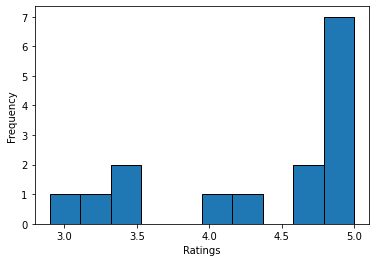

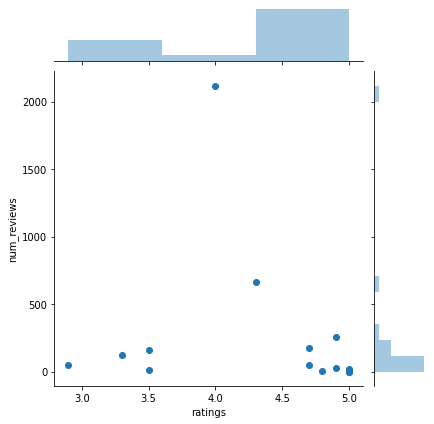

In [14]:
# Display rating frequency

plt.hist(full_amenities['ratings'], edgecolor = "black")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()
sns.jointplot(x="ratings", y="num_reviews", data=full_amenities);

In [15]:
# Sort the amenities by rating, and number of reviews

full_amenities.sort_values(by = ['num_reviews', 'ratings'], ascending = [False, False], inplace = True)
full_amenities.reset_index(drop = True);

In [16]:
# Select four recommended amenities for the User

recommended_amenities = full_amenities[0:4]

In [17]:
# Print recommended places

bty.print_recommended(
    recommended_amenities,
    'Highly recommended place to go:',
    'Other recommended places:',
    'name',
    'Address'
)

Highly recommended place to go: Powell Brewery Tasting Room at 75 Athletes Way, Vancouver

Other recommended places:
Shenanigans at 1082 Granville Street, Vancouver
Romer's at 1616 Alberni Street, Vancouver
The Cambie at 288 East Pender Street, Vancouver


### Get return route from Google Maps

In [18]:
# Peform the request with coordinates of recommended amenities, store the response

coordinates = bty.get_coordinates_from_locations(recommended_amenities)[0:]
response = bty.get_route_with_waypoints(lat_lon_origin, coordinates)

In [19]:
# Parse the travel information into a dataframe, and print travel information

travel_df = bty.get_travel_df(response)
bty.print_travel_info(travel_df)
travel_df.head()

Total Distance: 94.9 km
Estimated time needed (by cycling): 4 Hours 19 Minutes


start_address  \
0      657 Folsom St, Coquitlam, BC V3J 5A4, Canada   
1     1357 Powell St, Vancouver, BC V5L 1G8, Canada   
2     1251 Robson St, Vancouver, BC V6E 1C1, Canada   
3  101 Morrissey Rd, Port Moody, BC V3H 5N1, Canada   
4   300 W Cordova St, Vancouver, BC V6B 2N3, Canada   

                                        end_address distance        duration  \
0     1357 Powell St, Vancouver, BC V5L 1G8, Canada  18.6 km   1 hour 9 mins   
1     1251 Robson St, Vancouver, BC V6E 1C1, Canada   4.3 km         19 mins   
2  101 Morrissey Rd, Port Moody, BC V3H 5N1, Canada  26.2 km  1 hour 39 mins   
3   300 W Cordova St, Vancouver, BC V6B 2N3, Canada  24.8 km  1 hour 33 mins   
4      657 Folsom St, Coquitlam, BC V3J 5A4, Canada  21.0 km  1 hour 28 mins   

   distance_km  hour  minutes  
0         18.6     1        0  
1          4.3     0       19  
2         26.2     1        0  
3         24.8     1        0  
4         21.0     1        0

In [20]:
# Parse the route into a dataframe to save to file

route_df = bty.get_route_df(response)
route_df.head()

start_lat   start_lon    end_lat     end_lon distance duration  \
0  49.256989 -122.864798  49.256236 -122.864814     84 m    1 min   
1  49.256236 -122.864814  49.256381 -122.879846   1.1 km   4 mins   
2  49.256381 -122.879846  49.256617 -122.879844     26 m    1 min   
3  49.256617 -122.879844  49.256797 -122.893072   1.0 km   3 mins   
4  49.256797 -122.893072  49.253440 -122.893012   0.4 km   2 mins   

                                instructions  
0  Head south on Folsom St toward Foster Ave  
1                 Turn right onto Foster Ave  
2                Turn right onto Robinson St  
3                  Turn left onto Foster Ave  
4                    Turn left onto North Rd

### Display route with amenities

In [21]:
# Display map of route, with the recommended amenities marked

poi = btm.get_recommended_places_basic(recommended_amenities)
btm.display_map(poi, response)

Map(center=[49.271170999999995, -122.9783371], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

## Find amenities along path from the user's location to friend's location

### Get route from Google

In [22]:
# Perform request and store the response

response = bty.get_route(lat_lon_origin, lat_lon_destination)

In [23]:
# Get path dataframe from the response

path_df = bty.get_route_df(response)

In [24]:
# Get recommended path

by = int(len(path_df)/4)
length = len(path_df)
path_recommended_df = path_df[1:length:by]
path_recommended_df['lat'] = path_recommended_df['start_lat']
path_recommended_df['lon'] = path_recommended_df['start_lon']

In [25]:
# Get ratings again?

coordinate_list_2 = bty.get_coordinates_from_locations(path_recommended_df)

ls_nearby = []
progress = 1
print("Retrieving necessary information......")
for i in (coordinate_list_2):
    print("In progress (",progress," /", len(coordinate_list_2), ")")
    ls_nearby.append(bty.search_place_nearby(i,bty.API_KEY))
    progress += 1
print("Retreiveing Completed!")

Retrieving necessary information......
In progress ( 1  / 4 )
In progress ( 2  / 4 )
In progress ( 3  / 4 )
In progress ( 4  / 4 )
Retreiveing Completed!


In [26]:
# Use info from list to create nearby amenities dataframe

ls_recom = bty.getInfoFromGmapList(ls_nearby)

column_names1 = ['lat', 'lon', 'Address', 'Name', 'Category','place_id', 'ratings', 'num_reviews']
nearby_df = pd.DataFrame(ls_recom, columns=column_names1)
nearby_df = nearby_df.dropna().reset_index(drop = True)

In [27]:
# Filter out "boring" category and name types

nearby_df= nearby_df[nearby_df['Category'].apply(bty.haveBoringCategories) == False]
nearby_df= nearby_df[nearby_df['Name'].apply(bty.haveBoringNames) == False]
nearby_df = nearby_df.sort_values(by = ['num_reviews', 'ratings'], ascending = [False, False]).reset_index(drop = True)
nearby_df.head()

lat         lon                                     Address  \
0  49.277222 -123.080214                1146 Union Street, Vancouver   
1  49.277545 -123.079596                1175 Union Street, Vancouver   
2  49.266890 -123.002791       03 4501 Lougheed Highway P25, Burnaby   
3  49.277147 -123.080209  Bike Store, 1-1146 Union Street, Vancouver   
4  49.277372 -123.078006             1275 Venables Street, Vancouver   

                                                Name  \
0                           Landyachtz Factory Store   
1                                 Savoury Chef Foods   
2                                 Presotea Brentwood   
3            Landyachtz Bike Store - Service & Sales   
4  Nancy Ruth Deen | Vancouver's #1 Breakup Speci...   

                                            Category  \
0  [bicycle_store, point_of_interest, store, esta...   
1      [bar, food, point_of_interest, establishment]   
2     [cafe, food, point_of_interest, establishment]   
3                 [point_of_interest, establishment]   
4                 [point_of_interest, establishment]   

                      place_id  ratings  num_reviews  
0  ChIJ-7fYEmpxhlQRcvrrF9EtFqw      4.8        126.0  
1  ChIJ7_Jd9yZxhlQRWI1x9X2DSEM      4.7         41.0  
2  ChIJw4VGZnR3hlQRoptmoT-91PU      3.7         20.0  
3  ChIJmwT-Pb9xhlQR2hcSQhIBW_k      4.9          7.0  
4  ChIJ15Drj6xzhlQRYG5N3iEFg1Y      5.0          4.0

In [28]:
# Print recommended amenities to visit, as well as their locations

bty.print_recommended(
    nearby_df,
    'Recommended place to stop by on the way to the location given:',
    'Other recommended places  to stop by:',
    'Name',
    'Address'
)

Recommended place to stop by on the way to the location given: Landyachtz Factory Store at 1146 Union Street, Vancouver

Other recommended places  to stop by:
Savoury Chef Foods at 1175 Union Street, Vancouver
Presotea Brentwood at 03 4501 Lougheed Highway P25, Burnaby
Landyachtz Bike Store - Service & Sales at Bike Store, 1-1146 Union Street, Vancouver


In [29]:
# Select first four recommended places along the route

recommended_places_to_stop_by = nearby_df[0:4]

In [30]:
# Get the coordinates of the recommended amenities

coordinates_list_way = bty.get_coordinates_from_locations(recommended_places_to_stop_by)

In [31]:
# Get route with coordinates of the recommended amenities

response = bty.get_route_with_waypoints(
    lat_lon_origin, coordinates_list_way, lat_lon_destination
)

In [32]:
# Calculate distance and to travel one way

new_travel_df = bty.get_travel_df(response)
bty.print_travel_info(new_travel_df)

Total Distance: 41.69 km
Estimated time needed (by cycling): 2 Hours 35 Minutes


In [33]:
new_travel_df.head()

start_address  \
0    657 Folsom St, Coquitlam, BC V3J 5A4, Canada   
1    1146 Union St, Vancouver, BC V6A 2C6, Canada   
2    1175 Union St, Vancouver, BC V6A 2C7, Canada   
3  4501 Lougheed Hwy, Burnaby, BC V5C 0B3, Canada   
4    1146 Union St, Vancouver, BC V6A 2C6, Canada   

                                         end_address distance       duration  \
0       1146 Union St, Vancouver, BC V6A 2C6, Canada  18.4 km  1 hour 8 mins   
1       1175 Union St, Vancouver, BC V6A 2C7, Canada     93 m          1 min   
2     4501 Lougheed Hwy, Burnaby, BC V5C 0B3, Canada   7.3 km        34 mins   
3       1146 Union St, Vancouver, BC V6A 2C6, Canada   7.2 km        30 mins   
4  Stanley Park Seawall Path, Vancouver, BC V6G 3...   8.7 km        30 mins   

   distance_km  hour  minutes  
0       18.400     1        0  
1        0.093     0        1  
2        7.300     0       34  
3        7.200     0       30  
4        8.700     0       30

In [34]:
new_route_df = bty.get_route_df(response)
route_df.head()

start_lat   start_lon    end_lat     end_lon distance duration  \
0  49.256989 -122.864798  49.256236 -122.864814     84 m    1 min   
1  49.256236 -122.864814  49.256381 -122.879846   1.1 km   4 mins   
2  49.256381 -122.879846  49.256617 -122.879844     26 m    1 min   
3  49.256617 -122.879844  49.256797 -122.893072   1.0 km   3 mins   
4  49.256797 -122.893072  49.253440 -122.893012   0.4 km   2 mins   

                                instructions  
0  Head south on Folsom St toward Foster Ave  
1                 Turn right onto Foster Ave  
2                Turn right onto Robinson St  
3                  Turn left onto Foster Ave  
4                    Turn left onto North Rd